<a href="https://colab.research.google.com/github/saurabhsivakumar/amptorch/blob/active_learning/amptorch/active_learning/examples/neb_al_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ulissigroup/amptorch/blob/active_learning/amptorch/active_learning/examples/neb_al_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Installation of packages

In [1]:
!pip install -q git+https://github.com/saurabhsivakumar/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics

     |████████████████████████████████| 296kB 2.8MB/s 
     |████████████████████████████████| 6.7MB 4.0MB/s 
     |████████████████████████████████| 102kB 9.7MB/s 
     |████████████████████████████████| 2.1MB 50.3MB/s 
     |████████████████████████████████| 12.8MB 322kB/s 
     |████████████████████████████████| 110.5MB 44kB/s 
     |████████████████████████████████| 3.8MB 14.0MB/s 
     |████████████████████████████████| 512kB 47.9MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for simple-nn ... done

#### Build the NEBcalculator class, construct geometry and train with the active learner

In [2]:
import copy
import os
import numpy as np
import random

import torch

from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty
from amptorch.active_learning.al_utils import attach_sp_calc,CounterCalc
from amptorch.model import CustomMSELoss

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.optimize import QuasiNewton
from ase.neb import NEB, SingleCalculatorNEB
from ase.optimize import BFGS, FIRE, BFGSLineSearch,GPMin
from ase.optimize.sciopt import SciPyFminBFGS, SciPyFminCG
from ase import Atoms, Atom, units
from ase.build import molecule
from ase.visualize import view
from ase.io import read, write
from ase.build import fcc100, add_adsorbate,bcc100,fcc111
from ase.constraints import FixAtoms
from ase.neb import NEBTools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 


In [3]:
class NEBcalc:
    def __init__(self, starting_images, ml2relax=True, intermediate_samples=3,climb = False):
      """
      Computes a NEB given an initial and final image.

      Parameters
      ----------
      starting_images: list. Initial and final images to be used for the NEB.

      ml2relax: boolean. True to use ML to relax the initial and final structure guesses. 
      False if initial and final structures were relaxed beforehand.
      
      intermediate_samples: int. Number of intermediate samples to be used in constructing the NEB"""
      
      self.starting_images = copy.deepcopy(starting_images)
      self.ml2relax = ml2relax
      self.intermediate_samples = intermediate_samples
      self.isclimb = climb
      
    def run(self, calc, filename):
      """
      Runs NEB calculations.
      Parameters
      ----------
      calc: object. Calculator to be used to run method.
      filename: str. Label to save generated trajectory files."""
      
      initial = self.starting_images[0].copy()
      final = self.starting_images[-1].copy()

      if self.ml2relax:
        # Relax initial and final images
        ml_initial = initial
        ml_initial.set_calculator(calc)
        ml_final = final
        ml_final.set_calculator(calc)
        qn = BFGS(ml_initial, trajectory='initial.traj', logfile='initial_relax_log.txt')
        qn.run(fmax=0.005,steps = 200)
        qn = BFGS(ml_final, trajectory='final.traj', logfile='final_relax_log.txt')
        qn.run(fmax=0.005,steps = 200)
        initial = ml_initial.copy()
        final = ml_final.copy()

      initial.set_calculator(calc)
      final.set_calculator(calc)

      images = [initial]
      for i in range(self.intermediate_samples):
        image = initial.copy()
        image.set_calculator(calc) 
        images.append(image)
      images.append(final)

      print('NEB BEING BUILT')
      if self.isclimb == True:
        neb = SingleCalculatorNEB(images,climb=True)
      else:
        neb = SingleCalculatorNEB(images)
      neb.interpolate()
      print('NEB BEING OPTIMISED')
      opti = BFGS(neb, trajectory=filename+".traj", logfile='al_neb_log.txt')
      opti.run(fmax=0.005,steps = 200)
      print('NEB DONE')

      """ 
      The following code is used to visualise the NEB at every iteration 
      """
      built_neb = NEBTools(images)
      barrier, dE = built_neb.get_barrier()
      max_force = built_neb.get_fmax()
      fig = built_neb.plot_band()
      plt.show()
     
    def get_trajectory(self, filename):
      trajectory = trajectory = trajectory = ase.io.read(filename + ".traj", ":")
      return trajectory

In [4]:
#https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html#diffusion-tutorial
#Surface Diffusion Energy Barriers
#Building your structure

def construct_geometries(parent_calc, ml2relax):
  counter_calc = CounterCalc(parent_calc,'parent_databse')
  # Initial structure guess
  initial_slab = fcc100('Cu', size=(2, 2, 3))
  add_adsorbate(initial_slab, 'O', 1.7, 'hollow')
  initial_slab.center(axis=2, vacuum=4.0)
  mask = [atom.tag > 1 for atom in initial_slab]
  initial_slab.set_constraint(FixAtoms(mask=mask))

  initial_slab.set_calculator(counter_calc)

  # Final structure guess
  final_slab = initial_slab.copy()
  final_slab[-1].x += final_slab.get_cell()[0, 0] / 3
  final_slab.set_calculator(counter_calc)

  if ml2relax == False:
    qn = QuasiNewton(initial_slab, trajectory='initial.traj', logfile='initial_relax_log.txt')
    qn.run(fmax=0.01)
    qn = QuasiNewton(final_slab, trajectory='final.traj', logfile='final_relax_log.txt')
    qn.run(fmax=0.01)
    initial_slab = read("initial.traj", "-1")
    final_slab = read("final.traj", "-1")
  else:
    initial_slab = attach_sp_calc(initial_slab)
    final_slab = attach_sp_calc(final_slab)

  initial_force_calls = counter_calc.force_calls
  return initial_slab, final_slab, initial_force_calls

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0020          3.9036    77069.4531     +  0.4024
      2          0.0022          3.6600    67752.5625     +  0.1298


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0016          3.2933    54856.2891     +  0.1447
      4          0.0017          3.2740    54216.0234     +  0.1563
      5          0.0021          3.2490    53389.6797     +  0.1764
      6          0.0022          3.2432    53201.3125     +  0.1951
      7          0.0026          3.2291    52737.7109     +  0.2033
      8          0.0028          3.1805    51162.7773     +  0.2011
      9          0.0169          2.9019    42628.0625     +  0.2030
     10          0.0263          2.4799    31193.2969     +  0.1799
     11          0.0325          2.0706    21818.8535     +  0.1840
     12          0.0362          1.8361    17215.7148     +  0.1831
     13          0.0362          1.8360    17214.0254     +  0.1990
     14          0.0354          0.8013     3406.6179     +  0.2329
     15          0.0124          0.5696     1660.3135     +  0.1789
     16          0.0098          0.4134      876.6797     +  0.1877
     17          0.0123          0.3085      500

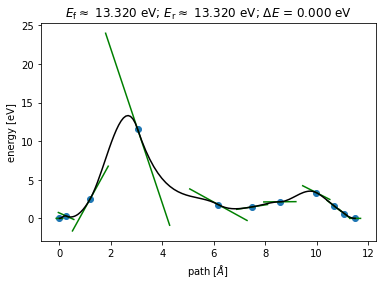

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.2527          5.0614        2.5239     +  0.1601
      2          0.2481          1.7964        0.0789     +  0.1756


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0529          1.5358        0.0402     +  0.1871
      4          0.0560          1.1005        0.0213     +  0.2107
      5          0.0284          0.7038        0.0085     +  0.2134
      6          0.0080          0.4508        0.0034     +  0.2214
      7          0.0073          0.3312        0.0018     +  0.2247
      8          0.0069          0.2596        0.0011     +  0.2291
      9          0.0064          0.2147        0.0008     +  0.2347
     10          0.0061          0.1936        0.0006     +  0.2126
     11          0.0059          0.1839        0.0006     +  0.2234
     12          0.0058          0.1807        0.0006     +  0.0266
     13          0.0058          0.1807        0.0006     +  0.2211
     14          0.0045          0.1217        0.0003     +  0.2265
     15          0.0042          0.1058        0.0002     +  0.2391
     16          0.0044          0.0950        0.0002     +  0.2323
     17          0.0043          0.0858        0

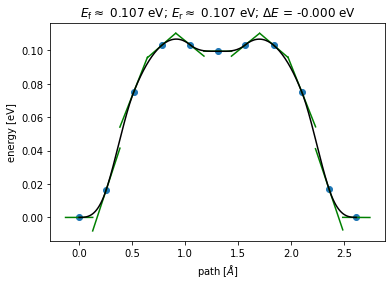

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.0851          4.7628        4.1706     +  0.1971


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2963          1.8230        0.1752     +  0.2297
      3          0.0528          1.4489        0.0689     +  0.2264
      4          0.0508          1.0444        0.0367     +  0.2501
      5          0.0277          0.6441        0.0138     +  0.2576
      6          0.0146          0.4127        0.0056     +  0.2597
      7          0.0093          0.3344        0.0036     +  0.2675
      8          0.0079          0.2835        0.0026     +  0.2639
      9          0.0075          0.2340        0.0018     +  0.2604
     10          0.0068          0.1976        0.0013     +  0.2647
     11          0.0062          0.1841        0.0011     +  0.2689
     12          0.0061          0.1809        0.0011     +  0.0875
     13          0.0061          0.1809        0.0011     +  0.2614
     14          0.0027          0.1284        0.0005     +  0.2699
     15          0.0021          0.1184        0.0004     +  0.2620
     16          0.0025          0.1119        0

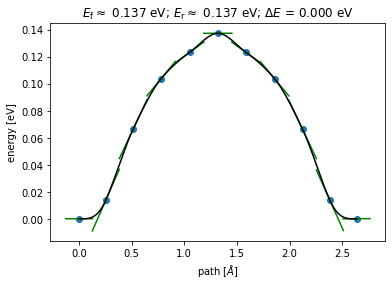

Terminating! Convergence criteria has been met


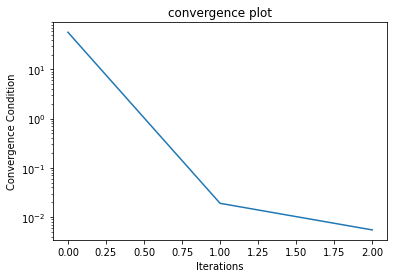

In [5]:
# Define symmetry functions
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 5.876798323827276  # EMT asap_cutoff: False

# Training parameters for the active learning framework
training_params = {
      "al_convergence": {"method": "neb_iter", "num_iterations": 7, "energy_tol": 0.006},
      "samples_to_retrain": 1,
      "Gs": Gs,
      "morse": True,
      "forcetraining": True,
      "cores": 1,
      "optimizer": torch.optim.LBFGS,
      "batch_size": 1000,
      "criterion": CustomMSELoss,
      "num_layers": 3,
      "num_nodes": 20,
      "force_coefficient": 0.04,
      "learning_rate": 1e-2,
      "epochs": 200,
      "test_split": 0,
      "shuffle": False,
      "verbose": 1,
      "filename": "neb_example",
      "file_dir": "./",
      "scheduler": {
            "policy": None,
            "params": None}
}

ml2relax = True
parent_calc = EMT()
initial, final, initial_force_calls = construct_geometries(parent_calc=parent_calc, ml2relax=ml2relax)
images = [initial]
images.append(final)

# Define AL scheme

learner = AtomisticActiveLearner(
    training_data=images,
    training_params=training_params,
    parent_calc=parent_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
total_neb_images = 11 # N + 2 where N is the number of intermediate images and 2 is for initial and final structures

amp_calc,total_iterations = learner.learn(
    atomistic_method=NEBcalc(
        starting_images=images, 
        ml2relax=ml2relax, 
        intermediate_samples=total_neb_images-2,
        climb = False), 
		query_strategy = random_query
	)

Visualize AL Results

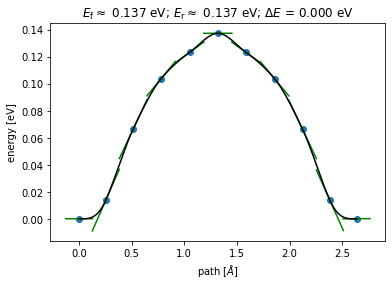

In [6]:
def neb_analysis(images, label, ax=None,save = False):
  nebtools = NEBTools(images)
  barrier, dE = nebtools.get_barrier()
  max_force = nebtools.get_fmax()
  fig = nebtools.plot_band(ax=ax)
  if save == True:
    fig.savefig(label+'.png', dpi=300)
  return barrier, dE, max_force
final_images = []
forces_list = []
images = read(f'neb_example_iter_{total_iterations-1}.traj@-{total_neb_images}:')
for image in images:
  final_images.append(image)
barrier_ml, dE_ml, max_force_ml = neb_analysis(final_images, label="ml_diffusion_neb",save = True)
forces_list.append(max_force_ml)

ML barrier pred = 0.13727140426635787, ml dE pred = 1.430511474609375e-06, ml max force = 0.004617495146440265
emt@ml barrier = 0.13069318426655493, emt@ml dE = 2.1564260345385833e-05, emt@ml max force = 0.1354012920670421
AL: Total number of force calls = 2 (initial data) + 9 (AL-NEB) = 11


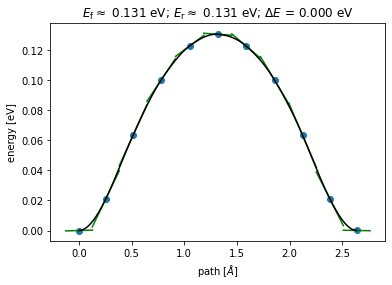

In [7]:
# to verify ml_computed images...evaluate with parent calculator
emt_evaluated_images = []
for image in images:
  image1 = image.copy()
  image1.set_calculator(EMT())
  emt_evaluated_images.append(image1)
  
barrier_emt_ml, dE_emt_ml, max_force_emt_ml = neb_analysis(emt_evaluated_images, label="emt@ml_diffusion_neb",save = True)
print(f"ML barrier pred = {barrier_ml}, ml dE pred = {dE_ml}, ml max force = {max_force_ml}")
print(f"emt@ml barrier = {barrier_emt_ml}, emt@ml dE = {dE_emt_ml}, emt@ml max force = {max_force_emt_ml}")
print(f"AL: Total number of force calls = {initial_force_calls} (initial data) + {learner.parent_calls} (AL-NEB) = {initial_force_calls+learner.parent_calls}")

#### Code to generate true NEB

In [8]:
emt_counter = CounterCalc(EMT(),'EMT_database')

if ml2relax == False:
  # Load previously computed relaxed states
  initial_slab1 = read("initial.traj", "-1")
  final_slab1 = read("final.traj", "-1")
else:
  initial.set_calculator(emt_counter)
  final.set_calculator(emt_counter)
  qn = BFGS(initial, trajectory='parent_initial.traj', logfile='initial_relax_log.txt')
  qn.run(fmax=0.01, steps=200)
  qn = BFGS(final, trajectory='parent_final.traj', logfile='final_relax_log.txt')
  qn.run(fmax=0.01, steps=200)
  initial_slab1 = read("parent_initial.traj", "-1")
  final_slab1 = read("parent_final.traj", "-1")

images2 = [initial_slab1]
for i in range(total_neb_images - 2):
    image = final_slab1.copy()
    image.set_calculator(emt_counter)
    images2.append(image)
images2.append(final_slab1)

neb = SingleCalculatorNEB(images2)
neb.interpolate()
qn = BFGS(neb, trajectory='actual_neb.traj')
qn.run(fmax=0.01)

      Step     Time          Energy         fmax
BFGS:    0 18:30:41        4.219398        4.2912
BFGS:    1 18:30:41        3.945395        2.8756
BFGS:    2 18:30:42        3.792102        1.7733
BFGS:    3 18:30:43        3.720425        0.9263
BFGS:    4 18:30:43        3.697256        0.3456
BFGS:    5 18:30:44        3.690696        0.4069
BFGS:    6 18:30:44        3.676241        0.4106
BFGS:    7 18:30:45        3.666203        0.3065
BFGS:    8 18:30:46        3.660814        0.1879
BFGS:    9 18:30:46        3.659295        0.1566
BFGS:   10 18:30:47        3.658199        0.1411
BFGS:   11 18:30:48        3.656371        0.1073
BFGS:   12 18:30:48        3.655156        0.0884
BFGS:   13 18:30:49        3.654938        0.0545
BFGS:   14 18:30:50        3.654957        0.0278
BFGS:   15 18:30:50        3.654950        0.0174
BFGS:   16 18:30:51        3.654936        0.0118
BFGS:   17 18:30:51        3.654933        0.0106
BFGS:   18 18:30:52        3.654935        0.0073


True

Ef = 0.12946737969333807, dE = 3.8518514031693485e-06, max_force = 0.007305768327102706
Total number of force calls = 240


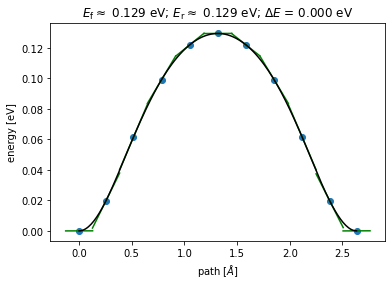

In [9]:
images = read(f'actual_neb.traj@-{total_neb_images}:')
nebtools = NEBTools(images)

Ef, dE, max_force = neb_analysis(images, label="actual_emt_neb")

print(f"Ef = {Ef}, dE = {dE}, max_force = {max_force}")
print(f"Total number of force calls = {initial_force_calls+emt_counter.force_calls}")

In [10]:
from ase.db import connect

db = connect('EMT_database.db')
count = 0
for row in db.select():
    atoms = row.toatoms()
    print(atoms)
    count += 1
print(count)

Atoms(symbols='Cu12O', pbc=[True, True, False], cell=[5.105310960166873, 5.105310960166873, 13.309999999999999], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7]), calculator=SinglePointCalculator(...))
Atoms(symbols='Cu12O', pbc=[True, True, False], cell=[5.105310960166873, 5.105310960166873, 13.309999999999999], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7]), calculator=SinglePointCalculator(...))
Atoms(symbols='Cu12O', pbc=[True, True, False], cell=[5.105310960166873, 5.105310960166873, 13.309999999999999], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7]), calculator=SinglePointCalculator(...))
Atoms(symbols='Cu12O', pbc=[True, True, False], cell=[5.105310960166873, 5.105310960166873, 13.309999999999999], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7]), calculator=SinglePointCalculator(...))
Atoms(symbols='Cu12O', pbc=[True, True, False], cell=[5.105310960166873, 5.105310960166873, 13.309999999999999], tags=..., constrain